In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
class TripletFlatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_images = {}
        self.classes = []
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            images = [
                os.path.join(class_path, f)
                for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ]
            if len(images) > 1:
                self.class_to_images[class_name] = images
                self.classes.append(class_name)

        self.samples = []
        for class_name, image_paths in self.class_to_images.items():
            for img_path in image_paths:
                self.samples.append((img_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        anchor_path, anchor_class = self.samples[idx]

        positive_candidates = [
            img for img in self.class_to_images[anchor_class]
            if img != anchor_path
        ]
        if not positive_candidates:
            raise ValueError(f"No positive samples available for class '{anchor_class}'")
        positive_path = random.choice(positive_candidates)

        negative_classes = [cls for cls in self.classes if cls != anchor_class]
        if not negative_classes:
            raise ValueError(f"No negative class available for '{anchor_class}'")
        negative_class = random.choice(negative_classes)
        negative_path = random.choice(self.class_to_images[negative_class])

        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative, anchor_class


In [3]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.Conv2d(128,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.Conv2d(256,256,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*24*24,256),
            nn.ReLU(),
            nn.Linear(256,128)
        )
    def forward_once(self,x):
        x = self.conv(x)
        x = self.fc(x)
        return x
    def forward(self,a,p,n):
        A = self.forward_once(a)
        P = self.forward_once(p)
        N = self.forward_once(n)
        return A,P,N

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

dataset = TripletFlatDataset(root_dir = "D:/Pythonn/Cancer/Data", transform=transform)
loader = DataLoader(dataset,batch_size=32,shuffle=True)

for anchor, positive, negative, label in loader:
    print(anchor.shape, positive.shape, negative.shape, label[0])
    break
print(len(loader))

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) Breast-benign
154


In [6]:
model = TripletNet().to(device)
criterion = nn.TripletMarginLoss(margin=1.0,p=2)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
torch.cuda.empty_cache()

In [7]:
for epoch in range(10):
    print(f"Starting epoch {epoch+1}")
    total_loss = 0

    
    for a, p, n, label in loader:
        a, p, n = a.to(device), p.to(device), n.to(device)

        A, P, N = model(a, p, n)
        loss = criterion(A, P, N)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(loader):.4f}")

Starting epoch 1
Epoch 1 | Loss: 0.3621
Starting epoch 2
Epoch 2 | Loss: 0.2561
Starting epoch 3
Epoch 3 | Loss: 0.2366
Starting epoch 4
Epoch 4 | Loss: 0.2253
Starting epoch 5
Epoch 5 | Loss: 0.2029
Starting epoch 6
Epoch 6 | Loss: 0.1765
Starting epoch 7
Epoch 7 | Loss: 0.1545
Starting epoch 8
Epoch 8 | Loss: 0.1577
Starting epoch 9
Epoch 9 | Loss: 0.1441
Starting epoch 10
Epoch 10 | Loss: 0.1359


In [9]:
model.eval()
embeddings = []
class_labels = []

with torch.no_grad():
    for a,p,n,label in loader:
        a = a.to(device)
        A,_,_ = model(a,p.to(device),n.to(device))
        embeddings.append(A.cpu())
        class_labels.extend(label)

In [10]:
embeddings = torch.cat(embeddings).numpy()

In [11]:
le = LabelEncoder()
encoded_labels = le.fit_transform(class_labels)

In [12]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

In [13]:
for i, label in enumerate(le.classes_):
    print(f"{label} → {i}")

Brain-No-tumor → 0
Brain-glioma → 1
Brain-meningioma → 2
Brain-pituitary → 3
Breast-benign → 4
Breast-malignant → 5
Breast-normal → 6
Lung-Bengin cases → 7
Lung-Malignant cases → 8
Lung-Normal cases → 9


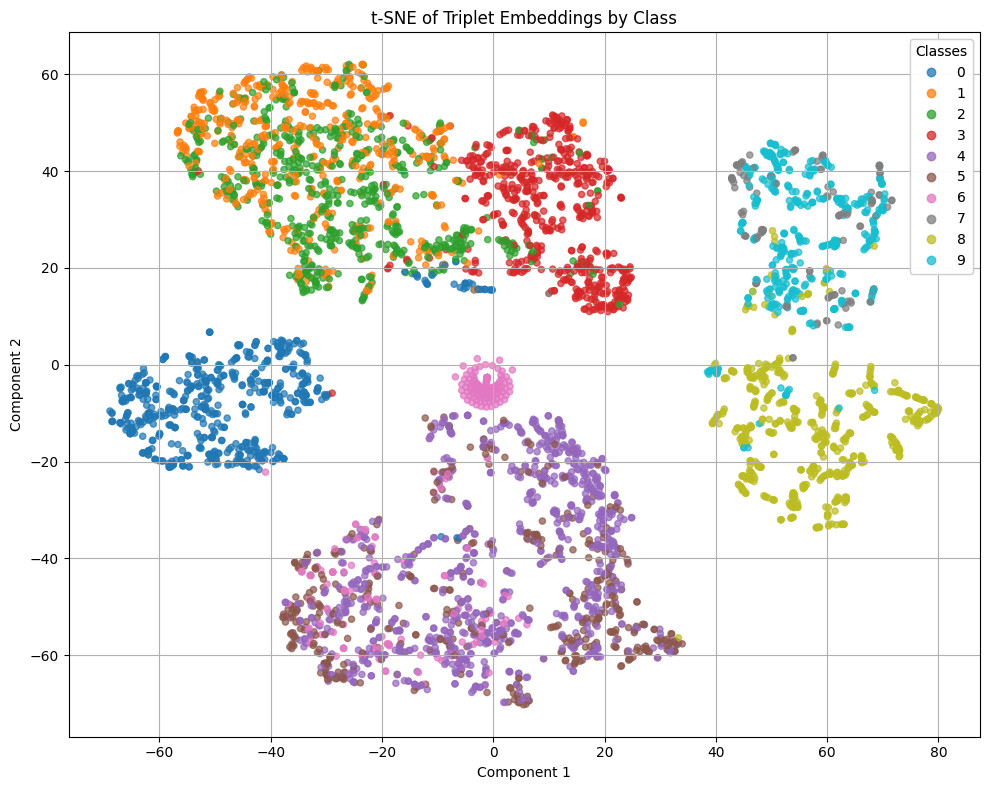

In [14]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=encoded_labels,
    cmap='tab10',
    alpha=0.7,
    s=20
)
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend)
plt.title("t-SNE of Triplet Embeddings by Class")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(embeddings, encoded_labels)

KNeighborsClassifier()

In [16]:
predicted_labels = knn.predict(embeddings)

In [17]:
acc = accuracy_score(encoded_labels, predicted_labels)
print("KNN Accuracy:", acc)
print(classification_report(encoded_labels, predicted_labels))

KNN Accuracy: 0.8692464358452139
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       578
           1       0.80      0.76      0.78       505
           2       0.78      0.80      0.79       601
           3       0.95      0.96      0.96       551
           4       0.79      0.91      0.85       891
           5       0.80      0.59      0.68       421
           6       0.85      0.74      0.79       266
           7       0.91      0.74      0.82       120
           8       0.98      0.98      0.98       561
           9       0.91      0.95      0.93       416

    accuracy                           0.87      4910
   macro avg       0.87      0.84      0.86      4910
weighted avg       0.87      0.87      0.87      4910

